In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [3]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
images.shape

id_to_labels = {
    0: "tshirt",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}


In [4]:
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # Input layer: 28x28 = 784
        self.fc1 = nn.Linear(28 * 28, 512)  
        self.fc2 = nn.Linear(512, 256)     
        self.fc3 = nn.Linear(256, 10)       
        self.relu = nn.ReLU()              
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # view - 28x28 picture to 784 one-dim vector
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [5]:
model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5


model.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass: compute the model output
        outputs = model(images)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass: compute gradients
        loss.backward()
        # Update weights
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/5], Loss: 0.4956
Epoch [2/5], Loss: 0.3660
Epoch [3/5], Loss: 0.3244
Epoch [4/5], Loss: 0.3000
Epoch [5/5], Loss: 0.2776


In [6]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

confusion_matrix = np.zeros((10, 10), dtype=int)

for true, pred in zip(all_labels, all_preds):
    confusion_matrix[true, pred] += 1

accuracies = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)

for i, acc in enumerate(accuracies):
    print(f'Dokładność klasy {i}: {acc:.2f}')

Dokładność klasy 0: 0.77
Dokładność klasy 1: 0.97
Dokładność klasy 2: 0.84
Dokładność klasy 3: 0.90
Dokładność klasy 4: 0.78
Dokładność klasy 5: 0.93
Dokładność klasy 6: 0.68
Dokładność klasy 7: 0.91
Dokładność klasy 8: 0.97
Dokładność klasy 9: 0.97


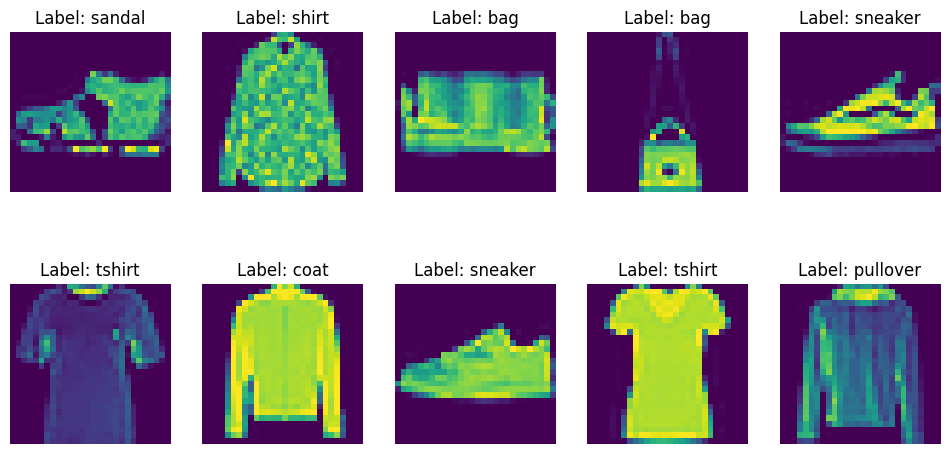

In [24]:
import matplotlib.pyplot as plt
num_images = 10

plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze())
    plt.title(f'Label: {id_to_labels[labels[i].item()]}')
    plt.axis('off')

plt.show()

**Autoencoder**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x


In [2]:

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    for images, _ in train_loader:
        images = images.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}')



Epoch [1/5], Loss: 0.1298
Epoch [2/5], Loss: 0.0738
Epoch [3/5], Loss: 0.0647
Epoch [4/5], Loss: 0.0593
Epoch [5/5], Loss: 0.0558


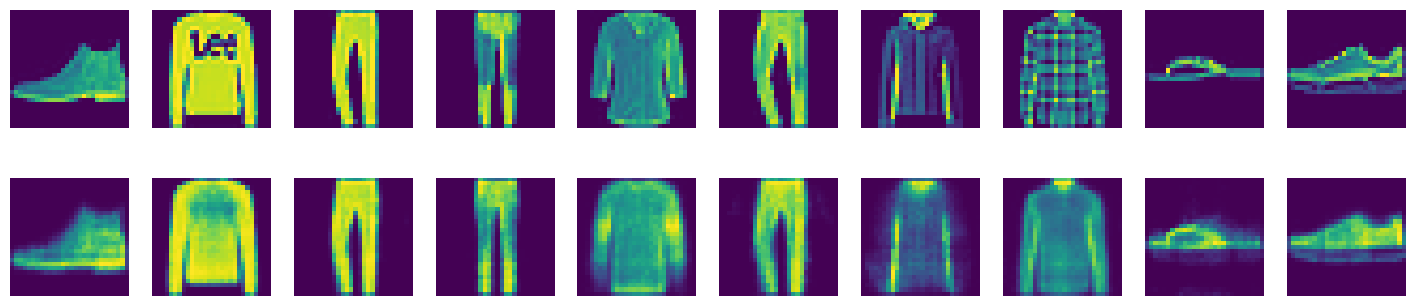

In [5]:

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        break 


images = images.cpu()
outputs = outputs.cpu()

fig, axes = plt.subplots(2, 10, figsize=(18, 4))
for i in range(10):
    axes[0, i].imshow(images[i].view(28, 28))
    axes[0, i].axis('off')

    axes[1, i].imshow(outputs[i].view(28, 28))
    axes[1, i].axis('off')

plt.show()
